# Fuzzy-marker-based Interactive segmentation with hierarchies

This notebook demonstrates the use of fuzzy markers for interactive image segmentation. The method and the algorithm to compute it in linear time are described in:

    Gabriel Barbosa da Fonseca, Benjamin Perret, Romain Negrel, Jean Cousty, and Silvio Jamil Ferzoli Guimaraes. 
    Fuzzy-marker-based segmentation using hierarchies. IAPR International Conference on Discrete Geometry and Mathematical Morphology (DGMM) 2021.

The user provides an *object* and a *background* marker and the algorithm constructs a segmentation. When providing markers, the user can select the marker location, size and membership degree of the marker. The membership degree values range from 0 to 1, with 1 meaning a marker with a *stronger* influence on the segmentation.

**Warning: This notebook requires ``%matplotlib notebook`` and won't work in evironment that doesn't support it (eg. Google Colab)**

In [1]:
#%%capture
#!pip install higra

In [2]:
import numpy as np
import imageio
%matplotlib notebook
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2
import higra as hg
from ipywidgets import interact, interactive
import ipywidgets as widgets

try:
    from utils import * # imshow, locate_resource, get_sed_model_file
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

Reading image and computing gradient

In [3]:
image = imageio.imread(locate_resource("3063.ppm"))
size = image.shape
# we reduce the image size a bit to fit on small screens...
image = resize(image, (int(size[0]*0.65), int(size[1]*0.65)), mode="reflect")
image = image.astype(np.float32) 
size = image.shape[:2]
# gradient computation

detector = cv2.ximgproc.createStructuredEdgeDetection(get_sed_model_file())
gradient_image = detector.detectEdges(image)

# add alpha channel to image for visualisation
image_alpha = np.pad(image, ((0,0),(0,0),(0,1)), mode='constant', constant_values=1) 

Computing the hierarchy

In [4]:
graph = hg.get_4_adjacency_graph(size)
edge_weights = hg.weight_graph(graph, gradient_image, hg.WeightFunction.mean)
tree, altitudes = hg.watershed_hierarchy_by_area(graph, edge_weights, canonize_tree=False)
altitudes += 1

In [11]:
# we construct a sketch of the saliency map just for illustration
sm = hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(tree, altitudes))**0.5
sm = sm[1::2,1::2]
sm = np.pad(sm, ((0,1),(0,1)), mode='edge')
sm = 1 - sm / np.max(sm)
sm = np.dstack([sm]*3)
#alpha channel
sm = np.pad(sm, ((0,0),(0,0),(0,1)), mode='constant', constant_values=1)

# this will be the background of the user interaction area : image | saliency map
base_image = np.hstack((image_alpha, sm))
# markers will store the user provided information: 
# first channel (red) corresponds to background
# second channel (green) corresponds to foreground
markers = np.zeros_like(image_alpha)

Widgets for adjusting marker size and membership degree

In [6]:
#creating widget for selecting membership degree and marker size
def f(Membership,Marker_Size):
    return Membership, Marker_Size

marker_bar = widgets.interactive(f, Membership=(0.0,1.0,0.01),Marker_Size=(1,10));

<IPython.core.display.Javascript object>


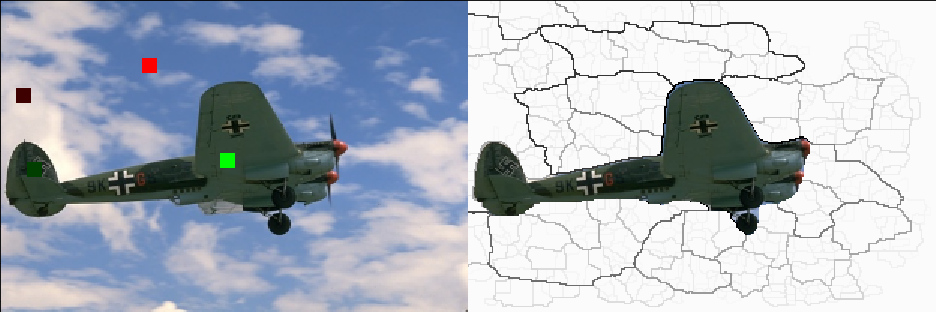

In [7]:
# we will make this figure interactive soon
fig, ax = imshow(base_image)

In [8]:
display(marker_bar);

interactive(children=(FloatSlider(value=0.5, description='Membership', max=1.0, step=0.01), IntSlider(value=5,…

Functions for computing the fuzzy connection values and fuzzy-marker-based segmentation

In [9]:
def fuzzy_connection_values(tree, altitudes, marker, alpha=lambda x: 1 / (x + 1e-9)):
    """
    Computes the fuzzy connection value from any leaf node of the hierarchy to the fuzzy marker in linear time.
    
    :param tree: input tree (must be a binary tree)
    :param altitudes: node altitudes of the input tree
    :param marker: leaf node marker values
    :param alpha: decreasing function from [0, 1] to [1, infinity[ such that alpha(0) > max(altitudes)
    :return: fuzzy connection values of the leaf nodes to the marker
    """

    # transform marker with alpha and compute min in each region
    alpha_marker = alpha(marker)
    min_alpha_marker = hg.accumulate_sequential(tree, alpha_marker, hg.Accumulators.min)
    
    # compute max(mu) for each region
    max_mu = hg.accumulate_sequential(tree, marker.astype(np.float64), hg.Accumulators.max)

    sibling = hg.attribute_sibling(tree)
    parents = tree.parents()

    # fuzzy connection value to sibling: max_alpha(mu(sibling(n))) * (1 - mu(sibling(n)) + altitudes(parent(n)))
    cv_to_sib = min_alpha_marker[sibling] * (1 - max_mu[sibling] + altitudes[parents])

    # recursion
    
    # initial value
    cv_to_sib[-1] = alpha(0) * (1 + altitudes[-1]) 
    
    #T(V \ n) = min ( T( parent(n)), cv_to_sib(n) )
    regional_connection_values = hg.propagate_sequential_and_accumulate(tree, cv_to_sib, hg.Accumulators.min)

    # Fuzzy connection values on the leaves
    # Ch(n,marker) = min(T(n), alpha_marker(n)(1 - mu(n)))
    fuzzy_connection_values = np.minimum(regional_connection_values[:tree.num_leaves()], alpha_marker * (1 - marker))
    
    return fuzzy_connection_values


def fuzzy_marker_based_segmentation(tree, altitudes, object_marker, background_marker):
    """
    Computes the fuzzy-marker-based segmentation of a n image with respect to a fuzzy object marker 
    and a fuzzy background marker.
    
    :param tree: input tree (must be a binary tree)
    :param altitudes: node altitudes of the input tree
    :param object_marker: leaf node object marker values
    :param background_marker: leaf node background marker 
    :return: binary semgnetation of the leaf nodes (1 if the pixel belongs to the object and 0 otherwise)
    
    """
    # Inputs: 'tree' a BPT tree of a given hierarchy
    #         'obj_func': array with size = tree.num_leaves() with values between 0 and 1 for the object 
    #         'bg_func': array with size = tree.num_leaves() with values between 0 and 1 for the background
    #         'shape': Width x Height shape to return a label matrix.
    # Outputs: 'result': array with size = tree.num_leaves() with 0 for background and 1 for object
    #          'labeled_mat': reshaped 'result' with shape = 'shape'
    
    result = np.zeros(tree.num_leaves())
    
    fuzzy_connection_value_to_object = fuzzy_connection_values(tree, altitudes, object_marker)
    fuzzy_connection_value_to_background = fuzzy_connection_values(tree, altitudes, background_marker)
    
    #computing the segmentation using the fuzzy connection values
    segmentation = (fuzzy_connection_value_to_object < fuzzy_connection_value_to_background)
    return segmentation

In [10]:
# Define a callback function that will update the drawing

def onclick(event):
    #remove prvious drawing
    ax.clear()
    
    # click position
    x = int(event.xdata) % size[1] # modulo click on the right image wraps on the first one
    y = int(event.ydata)
    marker_conf = marker_bar.result[0]
    marker_size = marker_bar.result[1]
    if event.button == 1: # left click
        markers[y-marker_size:y+marker_size, x-marker_size:x+marker_size, :]= (0, marker_conf, 0, 1) # green marker : object
    elif event.button == 3: # right click
        markers[y-marker_size:y+marker_size, x-marker_size:x+marker_size, :]= (marker_conf, 0, 0, 1) # red marker : background
    
    # compute binary segmentation from the two markers
    # Marker = RGBA --> W,H,RGBA
    # So, [:,:,0] = R, [:,:,1] = G
    object_marker = markers[:,:,1].reshape(tree.num_leaves())
    background_marker = markers[:,:,0].reshape(tree.num_leaves())
    segmentation = fuzzy_marker_based_segmentation(tree,altitudes, object_marker, background_marker)
    segmentation = segmentation.reshape(markers.shape[0:2])
    
    # redraw background
    ax.imshow(base_image, interpolation='none')
    
    # use the binary segmentation as the alpha channel to display the result
    tmp = np.copy(image)
    res = np.dstack((tmp, segmentation))
    
    # show markers on left image
    op = np.hstack((markers, res))
    ax.imshow(op, interpolation='none')
    

# Create a hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)